# Plant Disease Classification


## 1. Getting Setup


In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.8.0+cpu
torchvision version: 0.23.0+cpu


In [ ]:
from Some_Needed_Code import engine, engine_enhanced, data_setup
from Some_Needed_Code.helper_functions import download_data, set_seeds

c:\Users\owais\anaconda3\envs\ai-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 2. Prepare Dataset


**Pytorch expects the folder structure to be as the following:**

<div style="font-family: monospace; padding: 10px; border: 1px solid #ccc; background-color: #f9f9f9;">
    <div style="color: #007bff; font-weight: bold;">PlantVillage/</div>
    <div style="margin-left: 20px;">
        <div style="color: #6c757d;">├── </div>
        <div style="color: #007bff; font-weight: bold;">train/</div>
        <div style="margin-left: 20px; color: #343a40;">
            <div>│ &nbsp; ├── <span style="font-style: italic;">Apple___Black_rot/</span></div>
            <div>│ &nbsp; ├── <span style="font-style: italic;">Apple___healthy/</span></div>
            <div>│ &nbsp; ├── <span style="font-style: italic;">...</span></div>
        </div>
        <div style="color: #6c757d;">├── </div>
        <div style="color: #007bff; font-weight: bold;">val/</div>
        <div style="margin-left: 20px; color: #343a40;">
            <div>│ &nbsp; ├── <span style="font-style: italic;">Apple___Black_rot/</span></div>
            <div>│ &nbsp; ├── <span style="font-style: italic;">Apple___healthy/</span></div>
            <div>│ &nbsp; ├── <span style="font-style: italic;">...</span></div>
        </div>
        <div style="color: #6c757d;">├── </div>
        <div style="color: #007bff; font-weight: bold;">test/</div>
        <div style="margin-left: 20px; color: #343a40;">
            <div>│ &nbsp; ├── <span style="font-style: italic;">Apple___Black_rot/</span></div>
            <div>│ &nbsp; ├── <span style="font-style: italic;">Apple___healthy/</span></div>
            <div>│ &nbsp; ├── <span style="font-style: italic;">...</span></div>
        </div>
    </div>
</div>

**Let's prepare it!**


In [4]:
# Check if the data is balanced or not
import os
from collections import Counter

root_dir = "./plantvillage dataset/color"
counts = {
    cls: len(os.listdir(os.path.join(root_dir, cls)))
    for cls in os.listdir(root_dir)
    if os.path.isdir(os.path.join(root_dir, cls))
}

for cls, num in sorted(counts.items(), key=lambda x: x[1]):
    print(f"{cls}: {num} images")

total = sum(counts.values())
print("\nTotal images:", total)
print("Average per class:", total / len(counts))

Potato___healthy: 152 images
Apple___Cedar_apple_rust: 275 images
Peach___healthy: 360 images
Raspberry___healthy: 371 images
Tomato___Tomato_mosaic_virus: 373 images
Grape___healthy: 423 images
Strawberry___healthy: 456 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Apple___Black_rot: 621 images
Apple___Apple_scab: 630 images
Cherry_(including_sour)___healthy: 854 images
Tomato___Leaf_Mold: 952 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Pepper,_bell___Bacterial_spot: 997 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Tomato___Early_blight: 1000 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Strawberry___Leaf_scorch: 1109 images
Corn_(maize)___healthy: 1162 images
Grape___Black_rot: 1180 images
Corn_(maize)___Common_rust_: 1192 images
Grape___Esca_(Black_Measles): 1383 images
Tomato___Target_Spot: 1404 images
Pepper,_bell___healthy: 1478 images
Blueberry

In [5]:
import plotly.express as px
import pandas as pd

data = pd.DataFrame(list(counts.items()), columns=["Class", "Number of images"])

fig = px.bar(
    data,
    x="Number of images",
    y="Class",
    orientation="h",  # Ensures it's a horizontal bar chart
    title="Interactive Distribution of Images per Class",
)

fig.show()

**So, the dataset is severely imbalanced.**

**Based on this, will be applying _WeightedRandomSampler_ to the training set, after splitting the dataset.**


In [6]:
# # Splitting the Dataset
# from sklearn.model_selection import train_test_split
# import os, shutil, glob

# source_dir = "./plantvillage dataset/color"
# dest_dir = "./plantvillage dataset/color_splitted"

# classes = os.listdir(source_dir)
# for cls in classes:
#     imgs = glob.glob(os.path.join(source_dir, cls, "*.jpg"))
#     train, temp = train_test_split(imgs, test_size=0.3, random_state=42)
#     val, test = train_test_split(temp, test_size=0.5, random_state=42)

#     for name, split in zip([train, val, test], ["train", "val", "test"]):
#         os.makedirs(os.path.join(dest_dir, split, cls), exist_ok=True)
#         for img in name:
#             shutil.copy(img, os.path.join(dest_dir, split, cls))

In [7]:
# Prepare some transforms
transform = {
    "train": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

In [ ]:
# Create Datasets
data_dir = "./plantvillage dataset/color_splitted"
train_dataset = datasets.ImageFolder(
    os.path.join(data_dir, "train"), transform=transform["train"]
)
val_dataset = datasets.ImageFolder(
    os.path.join(data_dir, "val"), transform=transform["val"]
)

In [ ]:
# Applying WieghtedRandomSampler ONLY on the training set
from torch.utils.data import WeightedRandomSampler

targets = [label for _, label in train_dataset.samples]
class_counts = np.bincount(targets)
class_weights = 1.0 / class_counts
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(
    sample_weights, num_samples=len(sample_weights), replacement=True
)

In [ ]:
# Check if the sampler worked correctly
from collections import Counter

sampled_indices = list(sampler)
sampled_classes = [targets[i] for i in sampled_indices]
print(Counter(sampled_classes))

Counter({28: 1049, 34: 1037, 36: 1036, 24: 1034, 2: 1030, 17: 1029, 25: 1029, 23: 1028, 11: 1027, 27: 1026, 20: 1020, 33: 1017, 30: 1015, 14: 1015, 26: 1007, 22: 1007, 37: 1006, 12: 1004, 7: 1001, 0: 999, 6: 995, 5: 993, 1: 993, 3: 992, 16: 991, 31: 991, 15: 988, 10: 986, 4: 986, 19: 984, 13: 982, 18: 981, 21: 974, 35: 974, 29: 955, 9: 952, 8: 933, 32: 930})


In [ ]:
# Create DataLoaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

## 3. Getting the Pretrained ConvNext-Tiny Model Ready for Training


In [12]:
from torchvision import models

model_weights = models.ConvNeXt_Tiny_Weights.DEFAULT
model = models.convnext_tiny(weights=model_weights).to(device)
# model

In [15]:
# Freeze all base (feature extractor) layers
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier head
num_classes = 38  # PlantVillage has 38 classes
model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)

In [ ]:
from torchinfo import summary

# Get a summary of the model
summary(
    model,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [32, 3, 224, 224]    [32, 38]             --                   Partial
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 768, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                         [32, 3, 224, 224]    [32, 96, 56, 56]     --                   False
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 96, 56, 56]     (4,704)              False
│    │    └─LayerNorm2d (1)                             [32, 96, 56, 56]     [32, 96, 56, 56]     (192)                False
│    └─Sequential (1)                                   [32, 96, 56, 56]     [32, 96, 56, 56]     --                   False
│    │    └─CNBlock (0)                                 [32, 96, 56, 56]     [32, 96, 56, 56]     (79,296)             

## 4. Train the Model and Track the Results


In [17]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.classifier[2].parameters(), lr=0.001)

In [ ]:
# Train the Model
set_seeds()
results = engine_enhanced.train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device,
)

╭─────── 🚀 Training Engine ────────╮
│                                   │
│   STARTING TRAINING               │
│                                   │
│  Start Time: 2025-10-18 22:25:15  │
│  Device: cpu                      │
│  Epochs: 5                        │
│                                   │
╰──────────── engine.py ────────────╯

Epoch 1/5 — elapsed: 0:00:00

Epoch 1/5 [train]: 100%|█| 2375/2375 [41:18<00:00,  1.04s/it, Loss=0.3794, BatchLoss=0.0705, Acc=0.9216, Elapsed=0:41:18
Epoch 1/5 [val]  : 100%|██| 510/510 [08:36<00:00,  1.01s/it, Loss=0.1407, BatchLoss=0.0002, Acc=0.9610, Elapsed=0:08:36]


┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.3794 │   0.9216 │
│ Val          │ 0.1407 │   0.9610 │
└──────────────┴────────┴──────────┘

Epoch 2/5 — elapsed: 0:49:54

Epoch 2/5 [train]: 100%|█| 2375/2375 [41:43<00:00,  1.05s/it, Loss=0.1091, BatchLoss=0.0115, Acc=0.9714, Elapsed=0:41:43
Epoch 2/5 [val]  : 100%|██| 510/510 [08:24<00:00,  1.01it/s, Loss=0.0841, BatchLoss=0.0185, Acc=0.9737, Elapsed=0:08:24]


┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.1091 │   0.9714 │
│ Val          │ 0.0841 │   0.9737 │
└──────────────┴────────┴──────────┘

Epoch 3/5 — elapsed: 1:40:02

Epoch 3/5 [train]: 100%|█| 2375/2375 [1:18:29<00:00,  1.98s/it, Loss=0.0783, BatchLoss=0.0069, Acc=0.9778, Elapsed=1:18:
Epoch 3/5 [val]  : 100%|██| 510/510 [21:40<00:00,  2.55s/it, Loss=0.0770, BatchLoss=0.0176, Acc=0.9767, Elapsed=0:21:40]


┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.0783 │   0.9778 │
│ Val          │ 0.0770 │   0.9767 │
└──────────────┴────────┴──────────┘

Epoch 4/5 — elapsed: 3:20:11

Epoch 4/5 [train]: 100%|█| 2375/2375 [5:03:48<00:00,  7.67s/it, Loss=0.0648, BatchLoss=0.0869, Acc=0.9810, Elapsed=5:03:
Epoch 4/5 [val]  : 100%|██| 510/510 [09:18<00:00,  1.09s/it, Loss=0.0656, BatchLoss=0.0482, Acc=0.9801, Elapsed=0:09:18]


┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.0648 │   0.9810 │
│ Val          │ 0.0656 │   0.9801 │
└──────────────┴────────┴──────────┘

Epoch 5/5 — elapsed: 8:33:18

Epoch 5/5 [train]: 100%|█| 2375/2375 [43:01<00:00,  1.09s/it, Loss=0.0550, BatchLoss=0.1372, Acc=0.9833, Elapsed=0:43:01
Epoch 5/5 [val]  : 100%|██| 510/510 [08:49<00:00,  1.04s/it, Loss=0.0541, BatchLoss=0.0001, Acc=0.9829, Elapsed=0:08:49]


┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓
┃ Phase        ┃   Loss ┃ Accuracy ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩
│ Train        │ 0.0550 │   0.9833 │
│ Val          │ 0.0541 │   0.9829 │
└──────────────┴────────┴──────────┘

╭───────────── ✅ Done ──────────────╮
│                                    │
│   TRAINING COMPLETE 🎉             │
│                                    │
│  Finish Time: 2025-10-19 07:50:24  │
│  Total Duration: 9:25:08           │
│                                    │
╰────────────────────────────────────╯

In [ ]:
# Save the model
from Some_Needed_Code.utils import save_model

save_model(model=model, target_dir="./models", model_name="ConvNext-Tiny_First_Try.pth")

[INFO] Saving model to: models\ConvNext-Tiny_First_Try.pth


## 5. Evaluate the Model


In [ ]:
# Check the model size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path(
    "models\ConvNext-Tiny_First_Try.pth"
).stat().st_size // (
    1024 * 1024
)  # division converts bytes to megabytes (roughly)
print(
    f"Pretrained ConvNext-Tiny feature extractor model size: {pretrained_effnetb2_model_size} MB"
)

Pretrained ConvNext-Tiny feature extractor model size: 106 MB


In [33]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "val_loss": [...],
             "val_acc": [...]}
    """
    loss = results["train_loss"]
    val_loss = results["val_loss"]

    accuracy = results["train_acc"]
    val_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

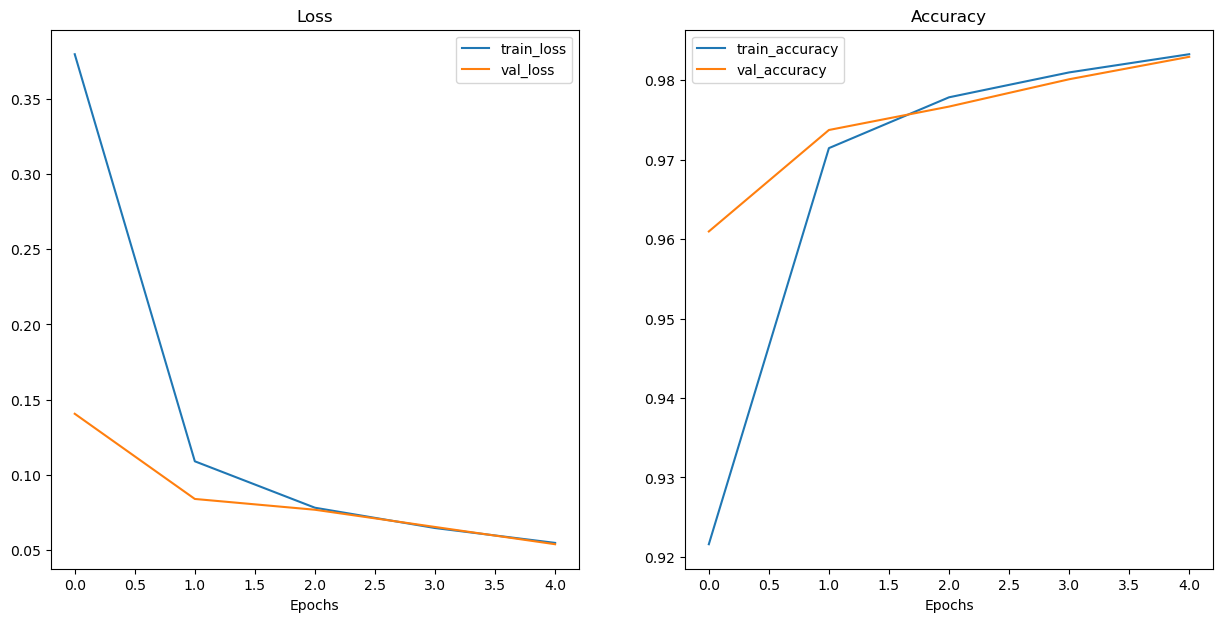

In [34]:
# Check the Loss Curves
plot_loss_curves(results)

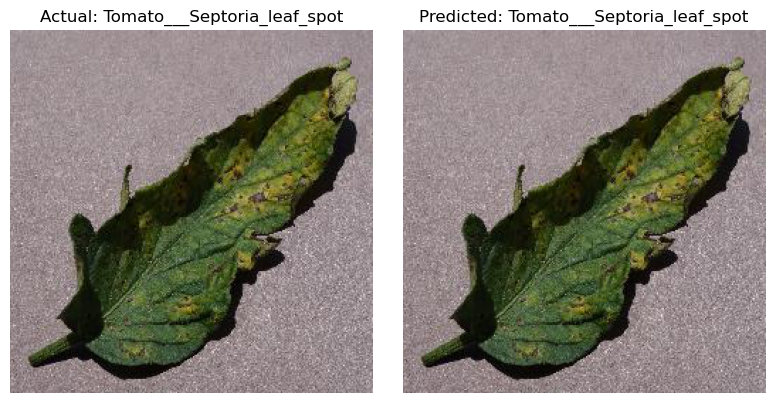

In [ ]:
import os
import random
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# --- CONFIG ---
test_dir = "./plantvillage dataset/color_splitted/test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- TRANSFORMS (yours) ---
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# --- PICK RANDOM IMAGE ---
classes = sorted(os.listdir(test_dir))
random_class = random.choice(classes)
class_dir = os.path.join(test_dir, random_class)
random_image = random.choice(os.listdir(class_dir))
img_path = os.path.join(class_dir, random_image)

# --- LOAD IMAGE ---
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

# --- PREDICT ---
model.eval()
with torch.no_grad():
    outputs = model(img_tensor)
    _, predicted = torch.max(outputs, 1)
pred_class = classes[predicted.item()]

# --- PLOT ORIGINAL & PREDICTED ---
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(Image.open(img_path))
plt.title(f"Actual: {random_class}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(Image.open(img_path))
plt.title(f"Predicted: {pred_class}")
plt.axis("off")

plt.tight_layout()
plt.show()